In [248]:
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import plot_decision_boundary, plot_predictions, accuracy_fn
import pathlib as Path
import requests

In [249]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

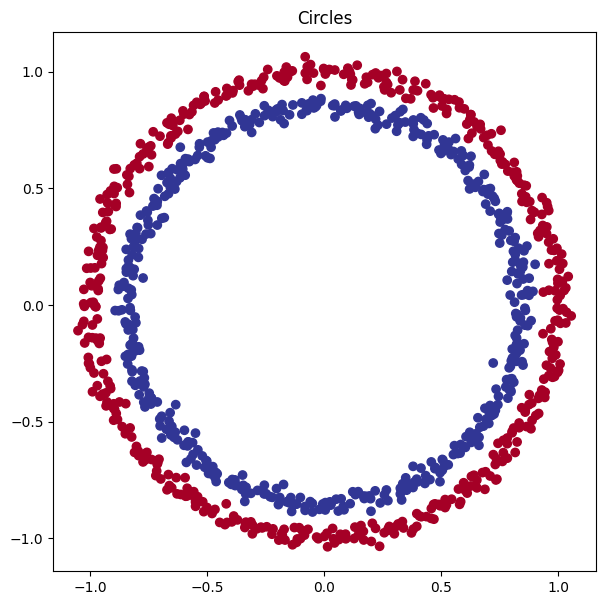

In [250]:
X_circle, y_circle = make_circles(n_samples=1000,
                                  shuffle=True,
                                  noise=0.025,
                                  random_state=50,
                                  factor=0.85)
lr_const = 0.075
hidden_layers = 32

plt.figure(figsize=(7, 7))
plt.title("Circles")
plt.scatter(x=X_circle[:, 0],
            y=X_circle[:, 1],
            c=y_circle,
            cmap=plt.cm.RdYlBu);

In [251]:
X_circle = torch.from_numpy(X_circle).type(torch.float)
y_circle = torch.from_numpy(y_circle).type(torch.float)

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X_circle, y_circle, train_size=0.75, random_state=50)

In [253]:
class CircleModelV1(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        
        self.linear_layer_1 = nn.Linear(in_features=input_features, out_features=hidden_layers)
        self.linear_layer_2 = nn.Linear(in_features=hidden_layers, out_features=output_features)
        
    def forward(self, x):
        return self.linear_layer_2(self.linear_layer_1(x))


model_1 = CircleModelV1(2, 1)
model_1_name = model_1.__class__.__name__
model_1_architecture = str(model_1).replace("(", " ").replace(")", " ")

In [254]:
loss_fn_1 = nn.BCEWithLogitsLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(),
                            lr=lr_const)
optimizer_1_name = optimizer_1.__class__.__name__
learning_rate_1 = optimizer_1.param_groups[0]["lr"]

In [255]:
torch.manual_seed(50)
torch.cuda.manual_seed(50)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs_count_1 = []
loss_values_1 = []
acc_values_1 = []
test_loss_values_1 = []
test_acc_values_1 = []

epochs_1 = 3050

for epoch_1 in range(epochs_1):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    loss_1 = loss_fn_1(y_logits, y_train)
    y_pred = torch.round(torch.sigmoid(y_logits))
    acc_1 = accuracy_fn(y_train, y_pred)
    optimizer_1.zero_grad()
    loss_1.backward()
    optimizer_1.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_loss_1 = loss_fn_1(test_logits, y_test)
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_acc_1 = accuracy_fn(y_test, test_pred)

        if epoch_1 % 50 == 0:
            epochs_count_1.append(epoch_1)
            loss_values_1.append(loss_1)
            test_loss_values_1.append(test_loss_1)
            acc_values_1.append(acc_1)
            test_acc_values_1.append(test_acc_1)

            print(f"Epoch: {epoch_1} | Loss: {loss_1:.3f} | Acc: {acc_1:.3f} | Test Loss: {test_loss_1:.3f} | Test Acc: {test_acc_1:.3f}")


Epoch: 0 | Loss: 0.711 | Acc: 47.467 | Test Loss: 0.703 | Test Acc: 52.800
Epoch: 50 | Loss: 0.693 | Acc: 48.933 | Test Loss: 0.695 | Test Acc: 44.400
Epoch: 100 | Loss: 0.693 | Acc: 49.333 | Test Loss: 0.696 | Test Acc: 46.400
Epoch: 150 | Loss: 0.693 | Acc: 49.733 | Test Loss: 0.696 | Test Acc: 46.800
Epoch: 200 | Loss: 0.693 | Acc: 50.000 | Test Loss: 0.696 | Test Acc: 46.400
Epoch: 250 | Loss: 0.693 | Acc: 50.000 | Test Loss: 0.696 | Test Acc: 46.400
Epoch: 300 | Loss: 0.693 | Acc: 50.000 | Test Loss: 0.696 | Test Acc: 46.400
Epoch: 350 | Loss: 0.693 | Acc: 50.000 | Test Loss: 0.696 | Test Acc: 46.400
Epoch: 400 | Loss: 0.693 | Acc: 50.000 | Test Loss: 0.696 | Test Acc: 46.400
Epoch: 450 | Loss: 0.693 | Acc: 50.000 | Test Loss: 0.696 | Test Acc: 46.400
Epoch: 500 | Loss: 0.693 | Acc: 50.000 | Test Loss: 0.696 | Test Acc: 46.400
Epoch: 550 | Loss: 0.693 | Acc: 50.000 | Test Loss: 0.696 | Test Acc: 46.400
Epoch: 600 | Loss: 0.693 | Acc: 50.000 | Test Loss: 0.696 | Test Acc: 46.400
Ep

In [256]:
final_loss_1 = loss_values_1[-1]
final_acc_1 = acc_values_1[-1]
final_test_loss_1 = test_loss_values_1[-1]
final_test_acc_1 = test_acc_values_1[-1]

results_1 = {}
results_1["Model"] = model_1_name
results_1["Loss"] = final_loss_1.item()
results_1["Test Loss"] = final_test_loss_1.item()
results_1["Acc"] = final_acc_1
results_1["Test Acc"] = final_test_acc_1

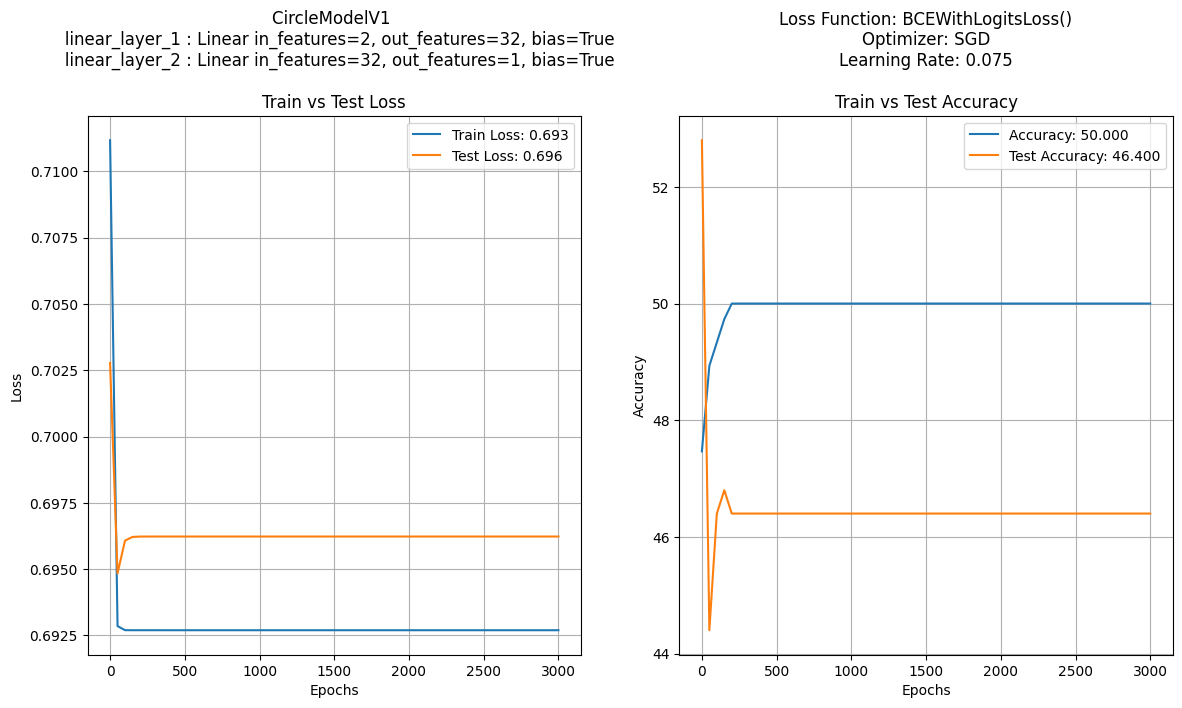

In [257]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(epochs_count_1, np.array(torch.tensor(loss_values_1).numpy()), label=f"Train Loss: {final_loss_1:.3f}")
plt.plot(epochs_count_1, np.array(torch.tensor(test_loss_values_1).numpy()), label=f"Test Loss: {final_test_loss_1:.3f}")
plt.title(f"{model_1_architecture}\nTrain vs Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(epochs_count_1, np.array(torch.tensor(acc_values_1).numpy()), label=f"Accuracy: {final_acc_1:.3f}")
plt.plot(epochs_count_1, np.array(torch.tensor(test_acc_values_1).numpy()), label=f"Test Accuracy: {final_test_acc_1:.3f}")
plt.title(f"Loss Function: {loss_fn_1}\nOptimizer: {optimizer_1_name}\nLearning Rate: {learning_rate_1}\n\nTrain vs Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

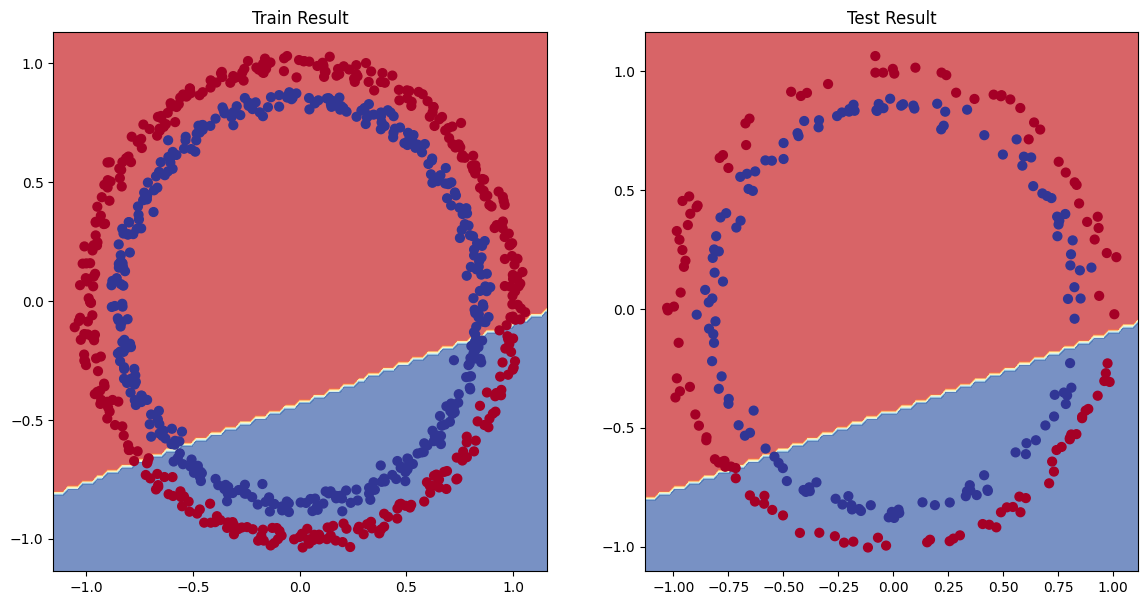

In [258]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.title("Train Result")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test Result")
plot_decision_boundary(model_1, X_test, y_test)

In [259]:
class CircleModelV2(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=input_features, out_features=hidden_layers)
        self.linear_layer_2 = nn.Linear(in_features=hidden_layers, out_features=output_features)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.linear_layer_2(self.relu(self.linear_layer_1(x)))

model_2 = CircleModelV2(2, 1).to(device)

def get_model_info(model):
    model_name = model.__class__.__name__
    model_architecture = str(model).replace("(", " ").replace(")", " ")
    return model_name, model_architecture
model_2_name, model_2_architecture = get_model_info(model_2)

In [260]:
loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer_2 = torch.optim.SGD(params=model_2.parameters(),
                              lr=lr_const)

def get_optimizer_info(optimizer):
    optimizer_name = optimizer.__class__.__name__
    learning_rate = optimizer.param_groups[0]["lr"]
    return optimizer_name, learning_rate
optimizer_2_name, learning_rate_2 = get_optimizer_info(optimizer_2)

In [261]:
def train_step(model, loss_fn, accuracy_fn, optimizer, X_train, y_train):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), acc


def test_step(model, loss_fn, accuracy_fn, X_test, y_test):
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    return test_loss.item(), test_acc

In [262]:
def train_loop(model, loss_fn, accuracy_fn, optimizer, X_train, y_train, X_test, y_test, epochs, print_freq, device=None):
    torch.manual_seed(50)
    torch.cuda.manual_seed(50)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    epochs_count = []
    loss_vals = []
    acc_vals = []
    test_loss_vals = []
    test_acc_vals = []
    
    for epoch in range(epochs):
        loss, acc = train_step(model, loss_fn, accuracy_fn, optimizer, X_train, y_train)
        test_loss, test_acc = test_step(model, loss_fn, accuracy_fn, X_test, y_test)

        if epoch % print_freq == 0:
            epochs_count.append(epoch)
            loss_vals.append(loss)
            acc_vals.append(acc)
            test_loss_vals.append(test_loss)
            test_acc_vals.append(test_acc)
            print(f"Epoch: {epoch} | Loss: {loss:.3f} | Acc: {acc:.3f} | Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}")
    return epochs_count, loss_vals, test_loss_vals, acc_vals, test_acc_vals

epochs_count_2, loss_values_2, test_loss_values_2, acc_values_2, test_acc_values_2 = train_loop(model_2, loss_fn_2, accuracy_fn, optimizer_2, 
                                                                                                X_train=X_train,
                                                                                                y_train=y_train,
                                                                                                X_test=X_test,
                                                                                                y_test=y_test,
                                                                                                epochs=3050,
                                                                                                print_freq=50,
                                                                                                device=device
                                                                                                )


Epoch: 0 | Loss: 0.700 | Acc: 49.733 | Test Loss: 0.696 | Test Acc: 52.400
Epoch: 50 | Loss: 0.695 | Acc: 49.333 | Test Loss: 0.697 | Test Acc: 44.000
Epoch: 100 | Loss: 0.692 | Acc: 51.467 | Test Loss: 0.695 | Test Acc: 45.200
Epoch: 150 | Loss: 0.690 | Acc: 51.733 | Test Loss: 0.694 | Test Acc: 46.400
Epoch: 200 | Loss: 0.688 | Acc: 53.067 | Test Loss: 0.692 | Test Acc: 48.000
Epoch: 250 | Loss: 0.686 | Acc: 53.600 | Test Loss: 0.691 | Test Acc: 49.200
Epoch: 300 | Loss: 0.684 | Acc: 53.867 | Test Loss: 0.689 | Test Acc: 49.600
Epoch: 350 | Loss: 0.682 | Acc: 54.133 | Test Loss: 0.687 | Test Acc: 50.000
Epoch: 400 | Loss: 0.680 | Acc: 54.800 | Test Loss: 0.685 | Test Acc: 51.200
Epoch: 450 | Loss: 0.678 | Acc: 57.467 | Test Loss: 0.684 | Test Acc: 53.200
Epoch: 500 | Loss: 0.676 | Acc: 60.000 | Test Loss: 0.681 | Test Acc: 55.600
Epoch: 550 | Loss: 0.673 | Acc: 61.467 | Test Loss: 0.679 | Test Acc: 57.600
Epoch: 600 | Loss: 0.671 | Acc: 62.133 | Test Loss: 0.677 | Test Acc: 58.400
Ep

In [263]:
def get_final_train_loop_values(losses, test_losses, accs, test_accs):  
    final_loss = losses[-1]
    final_test_loss = test_losses[-1]
    final_acc = accs[-1]
    final_test_acc = test_accs[-1]
    return final_loss, final_test_loss, final_acc, final_test_acc
final_loss_2, final_test_loss_2, final_acc_2, final_test_acc_2 = get_final_train_loop_values(loss_values_2, test_loss_values_2, acc_values_2, test_acc_values_2)

def collect_final_values(model_name, final__loss, final__test_loss, final__acc, final__test_acc):  
    return {
        "Model": model_name,
        "Loss": final__loss,
        "Test Loss": final__test_loss,
        "Acc": final__acc,
        "Test Acc": final__test_acc
    }
results_2 = collect_final_values(model_2_name, final_loss_2, final_test_loss_2, final_acc_2, final_test_acc_2)

Figure(1400x700)


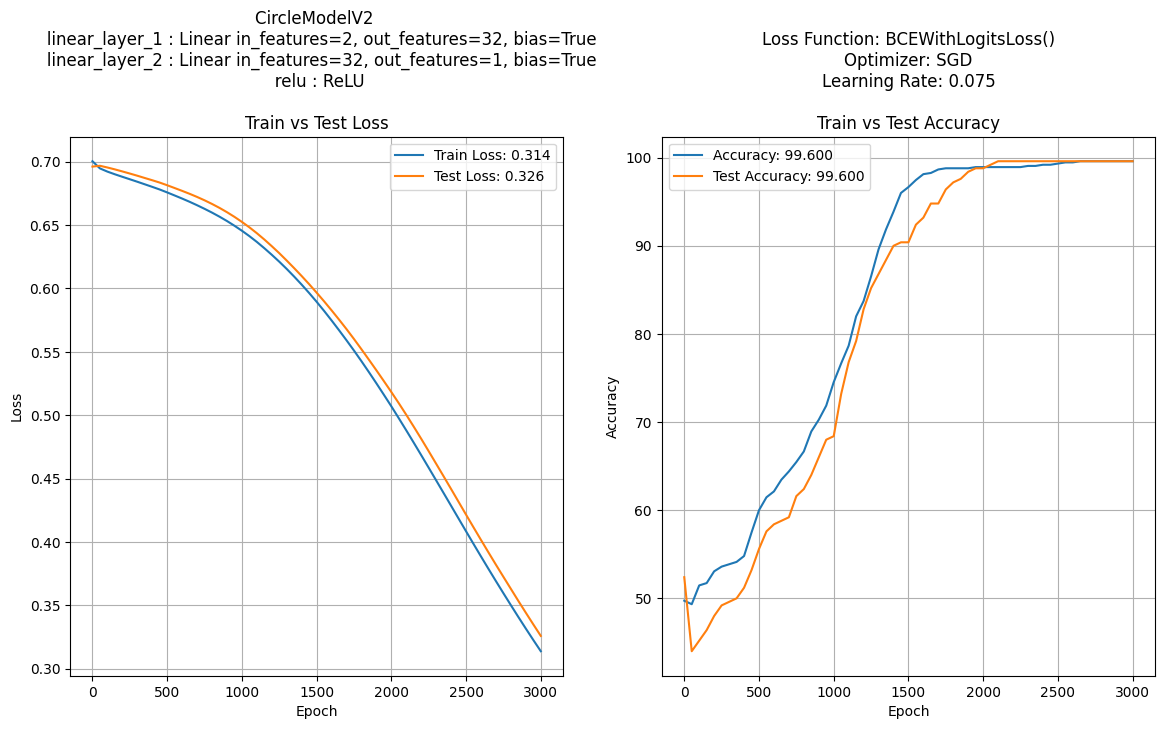

In [264]:
def plot_graphs(model_architecture, epochs__count, 
                loss__values, final__loss, 
                test__loss_values, final__test_loss, 
                acc__values, final__acc, 
                test__acc_values, final__test_acc, 
                loss__fn, optimizer__name, learning__rate):   
    
    fig = plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.grid(True)
    plt.title(f"{model_architecture}\nTrain vs Test Loss")
    plt.plot(epochs__count, np.array(torch.tensor(loss__values).numpy()), label=f"Train Loss: {final__loss:.3f}")
    plt.plot(epochs__count, np.array(torch.tensor(test__loss_values).numpy()), label=f"Test Loss: {final__test_loss:.3f}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend();
    plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.title(f"Loss Function: {loss__fn}\nOptimizer: {optimizer__name}\nLearning Rate: {learning__rate}\n\nTrain vs Test Accuracy")
    plt.plot(epochs__count, np.array(torch.tensor(acc__values).numpy()), label=f"Accuracy: {final__acc:.3f}")
    plt.plot(epochs__count, np.array(torch.tensor(test__acc_values). numpy()), label=f"Test Accuracy: {final__test_acc:.3f}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend();
    return fig

model_2_graphs = plot_graphs(model_2_architecture, epochs_count_2, 
                             loss_values_2, final_loss_2, 
                             test_loss_values_2, final_test_loss_2, 
                             acc_values_2, final_acc_2, 
                             test_acc_values_2, final_test_acc_2, 
                             loss_fn_2, optimizer_2_name, learning_rate_2)
print(model_2_graphs)

Figure(1400x700)


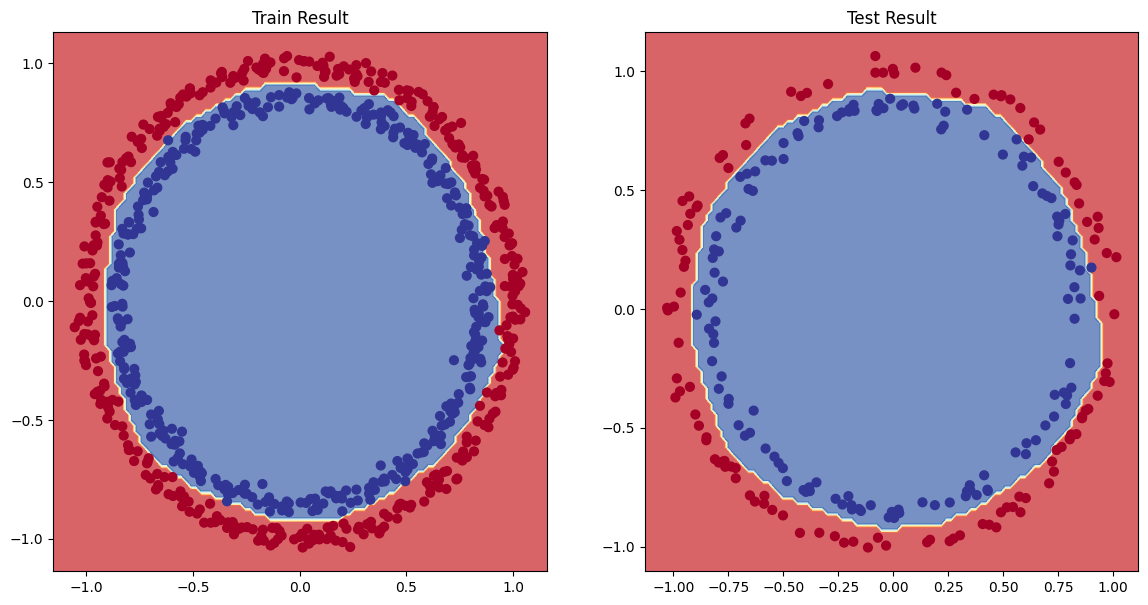

In [265]:
def plot_results(model, X_train, y_train, X_test, y_test):
    fig = plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.title("Train Result")
    plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test Result")
    plot_decision_boundary(model, X_test, y_test)
    return fig
model_2_results = plot_results(model_2, X_train, y_train, X_test, y_test)
print(model_2_results)

In [266]:
class CircleModelV3(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=input_features, out_features=hidden_layers)
        self.linear_layer_2 = nn.Linear(in_features=hidden_layers, out_features=output_features)
        self.gelu = nn.GELU()
    
    def forward(self, x):
        return self.linear_layer_2(self.gelu(self.linear_layer_1(x)))

model_3 = CircleModelV3(2, 1).to(device)

In [267]:
model_3_name, model_3_architecture = get_model_info(model_3)

In [268]:
loss_fn_3 = nn.BCEWithLogitsLoss()
optimizer_3 = torch.optim.SGD(params=model_3.parameters(),
                              lr=lr_const)
optimizer_3_name, learning_rate_3 = get_optimizer_info(optimizer_3)

In [269]:
epochs_count_3, loss_values_3, test_loss_values_3, acc_values_3, test_acc_values_3 = train_loop(model_3, loss_fn_3, accuracy_fn, optimizer_3, 
                                                                                                X_train, y_train,
                                                                                                X_test, y_test,
                                                                                                epochs=3050, print_freq=50,
                                                                                                device=None)

Epoch: 0 | Loss: 0.700 | Acc: 48.000 | Test Loss: 0.696 | Test Acc: 49.200
Epoch: 50 | Loss: 0.696 | Acc: 47.867 | Test Loss: 0.697 | Test Acc: 44.000
Epoch: 100 | Loss: 0.695 | Acc: 49.333 | Test Loss: 0.697 | Test Acc: 44.800
Epoch: 150 | Loss: 0.693 | Acc: 50.667 | Test Loss: 0.696 | Test Acc: 45.600
Epoch: 200 | Loss: 0.692 | Acc: 51.733 | Test Loss: 0.695 | Test Acc: 46.000
Epoch: 250 | Loss: 0.690 | Acc: 51.867 | Test Loss: 0.694 | Test Acc: 46.800
Epoch: 300 | Loss: 0.689 | Acc: 52.267 | Test Loss: 0.693 | Test Acc: 47.200
Epoch: 350 | Loss: 0.687 | Acc: 52.800 | Test Loss: 0.692 | Test Acc: 47.600
Epoch: 400 | Loss: 0.686 | Acc: 53.067 | Test Loss: 0.691 | Test Acc: 48.000
Epoch: 450 | Loss: 0.684 | Acc: 53.200 | Test Loss: 0.689 | Test Acc: 48.000
Epoch: 500 | Loss: 0.683 | Acc: 53.733 | Test Loss: 0.688 | Test Acc: 49.600
Epoch: 550 | Loss: 0.681 | Acc: 53.867 | Test Loss: 0.687 | Test Acc: 49.600
Epoch: 600 | Loss: 0.679 | Acc: 54.400 | Test Loss: 0.685 | Test Acc: 50.800
Ep

In [270]:
final_loss_3, final_test_loss_3, final_acc_3, final_test_acc_3 = get_final_train_loop_values(loss_values_3, test_loss_values_3, 
                                                                                             acc_values_3, test_acc_values_3)

In [271]:
results_3 = collect_final_values(model_3_name, final_loss_3, final_test_loss_3, final_acc_3, final_test_acc_3)

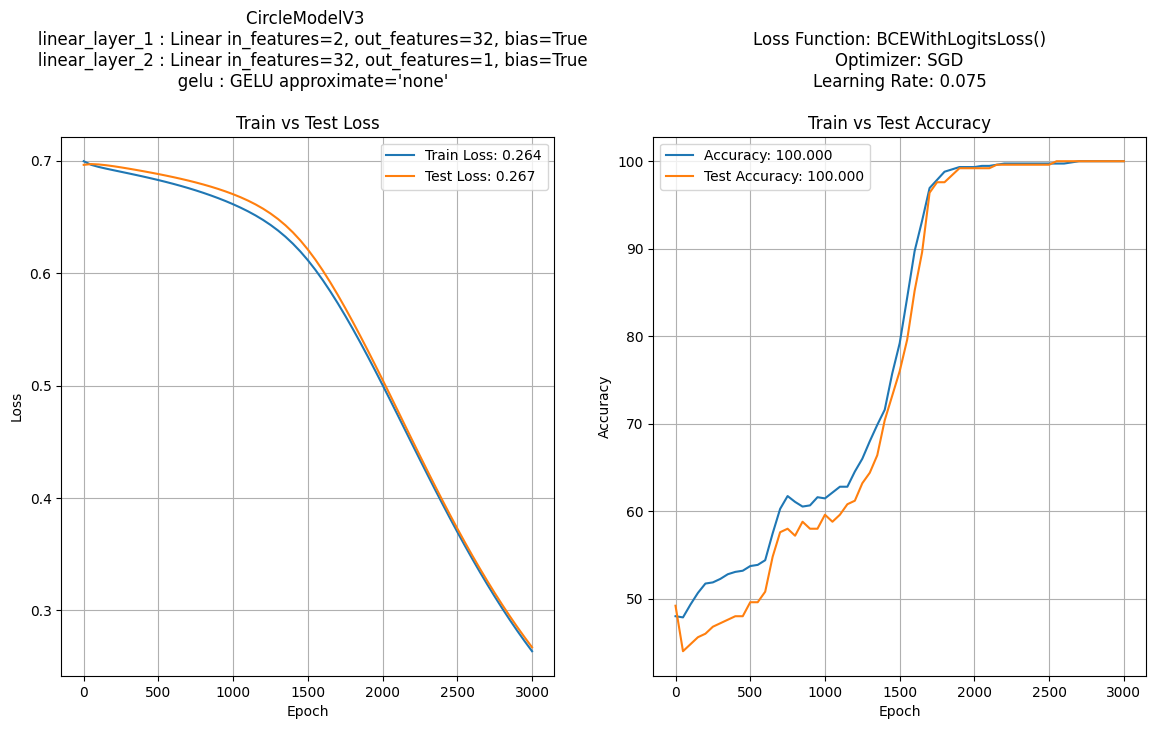

In [272]:
model_3_graphs = plot_graphs(model_3_architecture, epochs_count_3, 
                             loss_values_3, final_loss_3, test_loss_values_3, final_test_loss_3, 
                             acc_values_3, final_acc_3, test_acc_values_3, final_test_acc_3, 
                             loss_fn_3, optimizer_3_name, learning_rate_3)


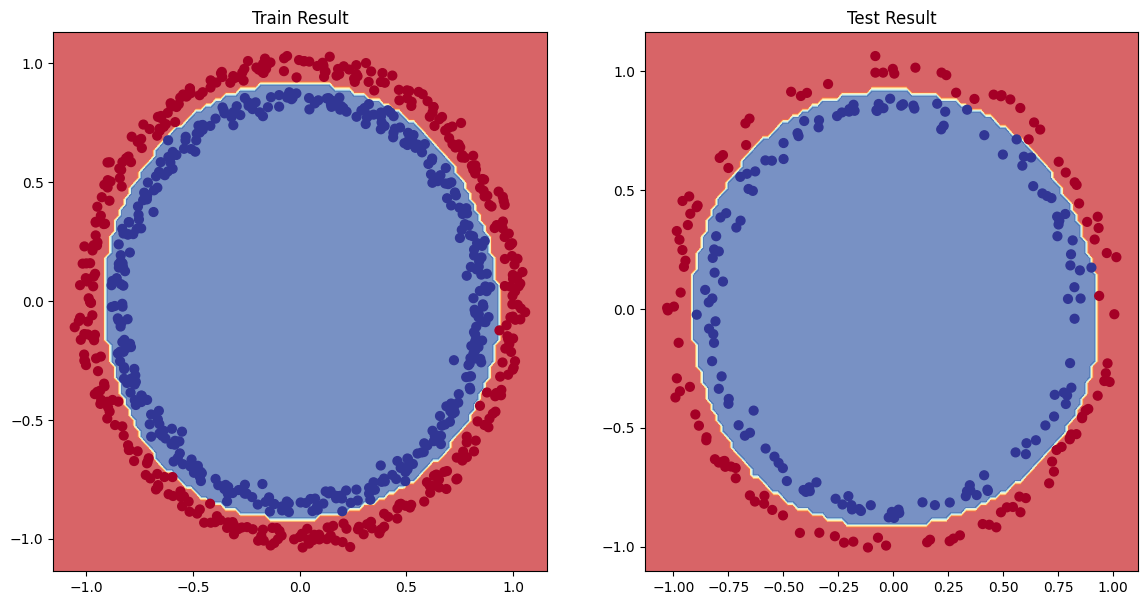

In [273]:
model_3_results = plot_results(model_3, X_train, y_train, X_test, y_test)

In [274]:
class CircleModelV4(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=input_features, out_features=hidden_layers)
        self.linear_layer_2 = nn.Linear(in_features=hidden_layers, out_features=output_features)
        self.silu = nn.SiLU()
    
    def forward(self, x):
        return self.linear_layer_2(self.silu(self.linear_layer_1(x)))

model_4 = CircleModelV4(2, 1).to(device)
model_4_name, model_4_architecture = get_model_info(model_4)

In [275]:
loss_fn_4 = nn.BCEWithLogitsLoss()
optimizer_4 = torch.optim.SGD(params=model_4.parameters(),
                              lr=lr_const)
optimizer_4_name, learning_rate_4 = get_optimizer_info(optimizer_4)

In [276]:
epochs_count_4, loss_values_4, test_loss_values_4, acc_values_4, test_acc_values_4 = train_loop(model_4, loss_fn_4, accuracy_fn, optimizer_4,
                                                                                                X_train, y_train,
                                                                                                X_test, y_test,
                                                                                                epochs=3050, print_freq=50,
                                                                                                device=None)

Epoch: 0 | Loss: 0.699 | Acc: 47.200 | Test Loss: 0.696 | Test Acc: 50.800
Epoch: 50 | Loss: 0.696 | Acc: 47.200 | Test Loss: 0.696 | Test Acc: 47.200
Epoch: 100 | Loss: 0.695 | Acc: 48.000 | Test Loss: 0.697 | Test Acc: 44.000
Epoch: 150 | Loss: 0.694 | Acc: 49.867 | Test Loss: 0.697 | Test Acc: 44.000
Epoch: 200 | Loss: 0.693 | Acc: 50.533 | Test Loss: 0.696 | Test Acc: 44.400
Epoch: 250 | Loss: 0.692 | Acc: 51.200 | Test Loss: 0.696 | Test Acc: 45.200
Epoch: 300 | Loss: 0.692 | Acc: 51.733 | Test Loss: 0.695 | Test Acc: 45.600
Epoch: 350 | Loss: 0.691 | Acc: 52.000 | Test Loss: 0.695 | Test Acc: 45.600
Epoch: 400 | Loss: 0.690 | Acc: 52.267 | Test Loss: 0.694 | Test Acc: 45.600
Epoch: 450 | Loss: 0.689 | Acc: 52.800 | Test Loss: 0.694 | Test Acc: 46.000
Epoch: 500 | Loss: 0.688 | Acc: 53.333 | Test Loss: 0.693 | Test Acc: 46.800
Epoch: 550 | Loss: 0.688 | Acc: 53.467 | Test Loss: 0.692 | Test Acc: 46.800
Epoch: 600 | Loss: 0.687 | Acc: 53.600 | Test Loss: 0.692 | Test Acc: 47.200
Ep

In [277]:
final_loss_4, final_test_loss_4, final_acc_4, final_test_acc_4 = get_final_train_loop_values(loss_values_4, test_loss_values_4, acc_values_4, test_acc_values_4)

In [278]:
results_4 = collect_final_values(model_4_name, final_loss_4, final_test_loss_4, final_acc_4, final_test_acc_4)

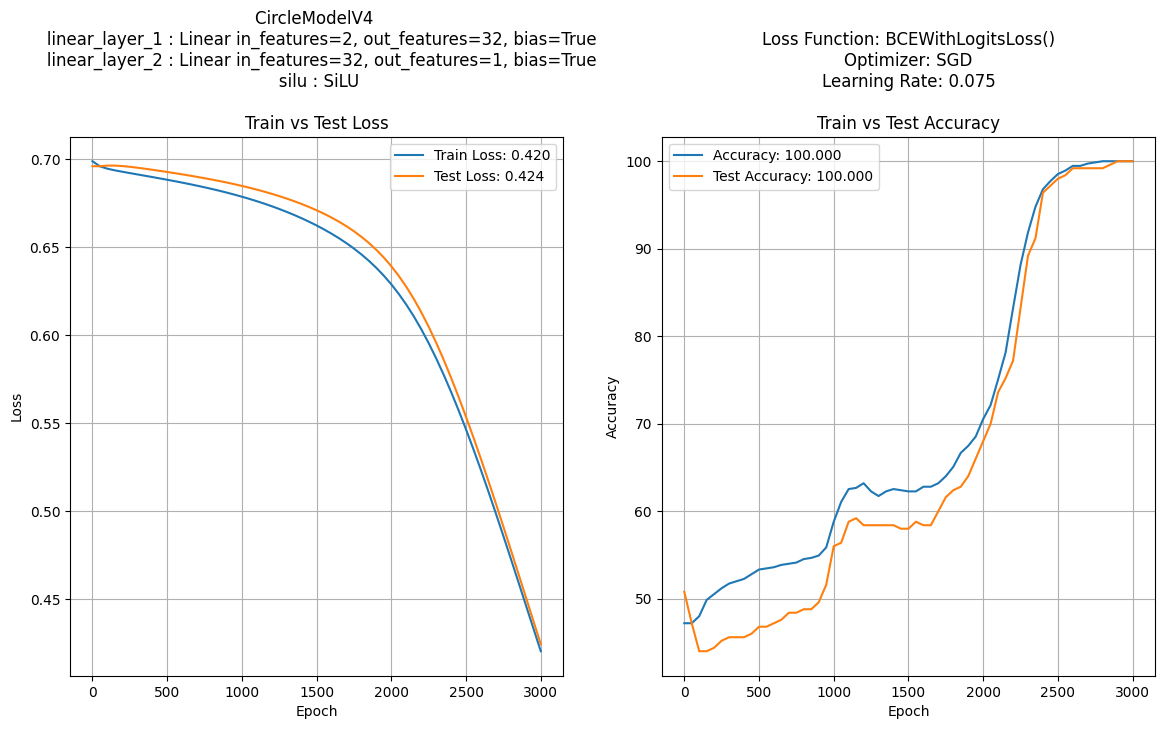

In [279]:
model_4_graphs = plot_graphs(model_4_architecture, epochs_count_4, loss_values_4, final_loss_4, test_loss_values_4, final_test_loss_4, acc_values_4, final_acc_4, test_acc_values_4, final_test_acc_4, loss_fn_4, optimizer_4_name, learning_rate_4)

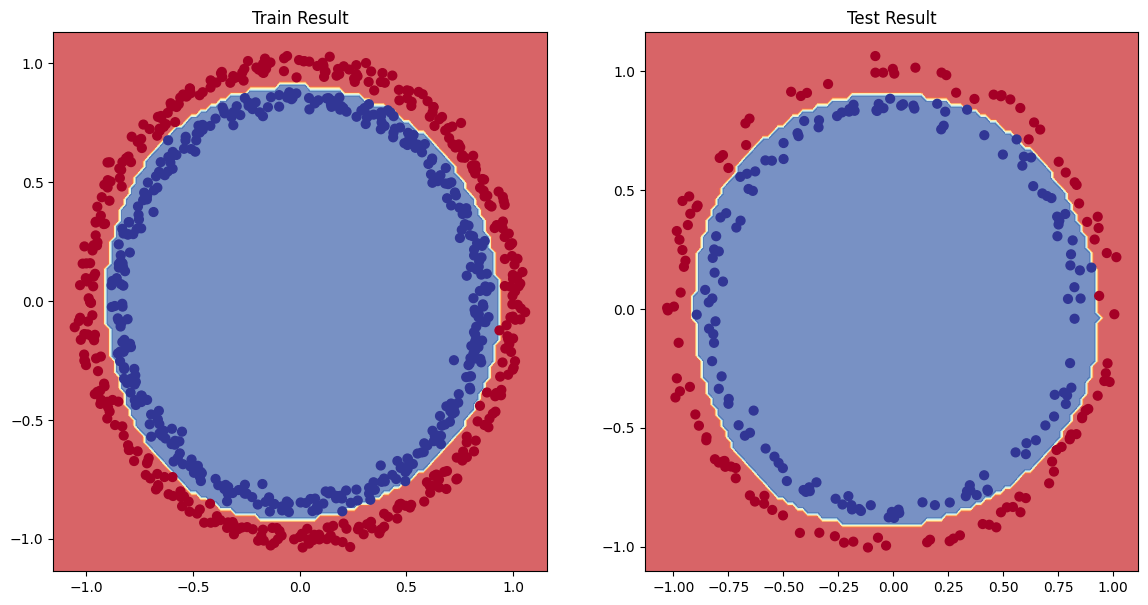

In [280]:
model_4_results = plot_results(model_4, X_train, y_train, X_test, y_test)

In [281]:
class CircleModelV5(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=input_features, out_features=hidden_layers)
        self.linear_layer_2 = nn.Linear(in_features=hidden_layers, out_features=output_features)
        self.celu = nn.CELU()
    
    def forward(self, x):
        return self.linear_layer_2(self.celu(self.linear_layer_1(x)))

model_5 = CircleModelV5(2, 1).to(device)
model_5_name, model_5_architecture = get_model_info(model_5)

In [282]:
loss_fn_5 = nn.BCEWithLogitsLoss()
optimizer_5 = torch.optim.SGD(params=model_5.parameters(),
                              lr=lr_const)
optimizer_5_name, learning_rate_5 = get_optimizer_info(optimizer_5)

In [283]:
epochs_count_5, loss_values_5, test_loss_values_5, acc_values_5, test_acc_values_5 = train_loop(model_5, loss_fn_5, accuracy_fn, optimizer_5,
                                                                                                X_train, y_train,
                                                                                                X_test, y_test,
                                                                                                epochs=3050, print_freq=50,
                                                                                                device=None)

Epoch: 0 | Loss: 0.705 | Acc: 47.333 | Test Loss: 0.699 | Test Acc: 53.600
Epoch: 50 | Loss: 0.695 | Acc: 48.000 | Test Loss: 0.696 | Test Acc: 42.000
Epoch: 100 | Loss: 0.694 | Acc: 49.333 | Test Loss: 0.697 | Test Acc: 47.600
Epoch: 150 | Loss: 0.693 | Acc: 49.733 | Test Loss: 0.697 | Test Acc: 47.200
Epoch: 200 | Loss: 0.693 | Acc: 50.000 | Test Loss: 0.696 | Test Acc: 48.000
Epoch: 250 | Loss: 0.692 | Acc: 50.667 | Test Loss: 0.696 | Test Acc: 49.200
Epoch: 300 | Loss: 0.691 | Acc: 51.467 | Test Loss: 0.695 | Test Acc: 48.400
Epoch: 350 | Loss: 0.691 | Acc: 51.867 | Test Loss: 0.695 | Test Acc: 48.800
Epoch: 400 | Loss: 0.690 | Acc: 52.533 | Test Loss: 0.694 | Test Acc: 49.600
Epoch: 450 | Loss: 0.690 | Acc: 52.667 | Test Loss: 0.694 | Test Acc: 49.600
Epoch: 500 | Loss: 0.689 | Acc: 53.067 | Test Loss: 0.694 | Test Acc: 49.200
Epoch: 550 | Loss: 0.689 | Acc: 53.200 | Test Loss: 0.693 | Test Acc: 48.400
Epoch: 600 | Loss: 0.688 | Acc: 53.467 | Test Loss: 0.693 | Test Acc: 48.400
Ep

In [284]:
final_loss_5, final_test_loss_5, final_acc_5, final_test_acc_5 = get_final_train_loop_values(loss_values_5, test_loss_values_5, acc_values_5, test_acc_values_5)

In [285]:
results_5 = collect_final_values(model_5_name, final_loss_5, final_test_loss_5, final_acc_5, final_test_acc_5)

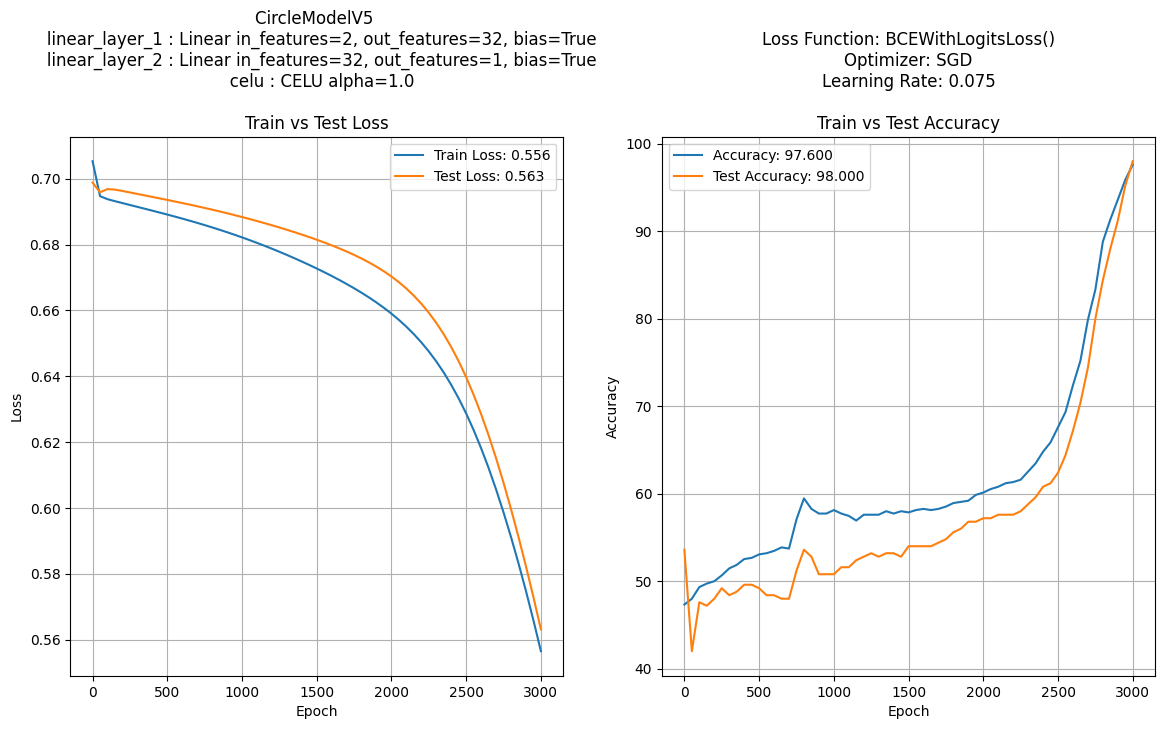

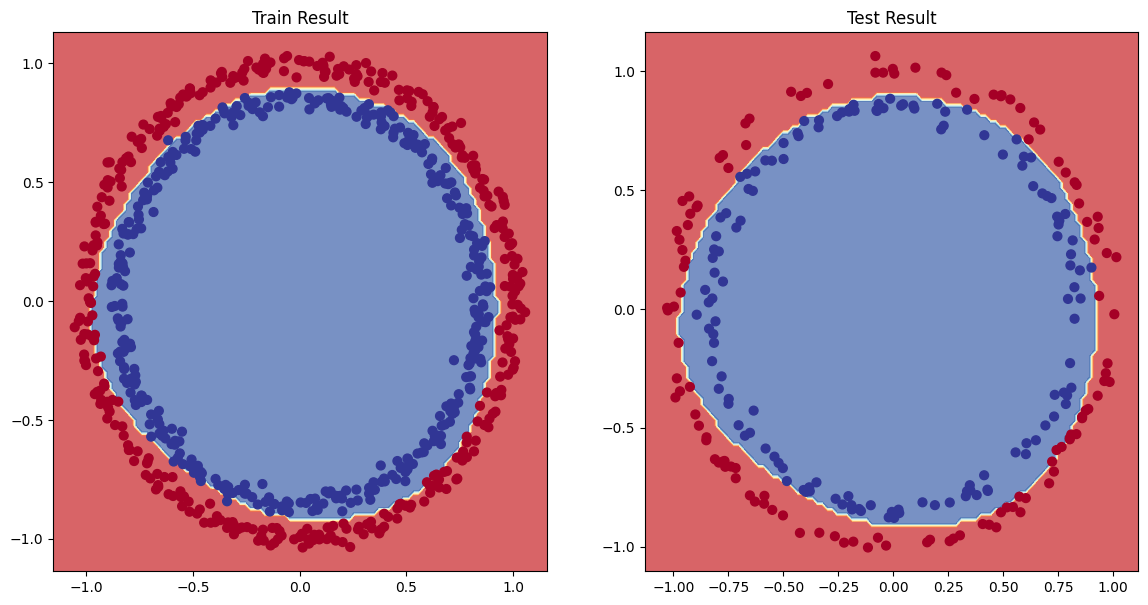

In [286]:
model_5_graphs = plot_graphs(model_5_architecture, epochs_count_5, loss_values_5, final_loss_5, test_loss_values_5, final_test_loss_5, acc_values_5, final_acc_5, test_acc_values_5, final_test_acc_5, loss_fn_5, optimizer_5_name, learning_rate_5)
model_5_results = plot_results(model_5, X_train, y_train, X_test, y_test)

In [287]:
class CircleModelV6(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_1 = nn.Linear(in_features=input_features, out_features=hidden_layers)
        self.linear_layer_2 = nn.Linear(in_features=hidden_layers, out_features=output_features)
        self.elu = nn.ELU()
    
    def forward(self, x):
        return self.linear_layer_2(self.elu(self.linear_layer_1(x)))

model_6 = CircleModelV6(2, 1).to(device)
model_6_name, model_6_architecture = get_model_info(model_6)

In [288]:
loss_fn_6 = nn.BCEWithLogitsLoss()
optimizer_6 = torch.optim.SGD(params=model_6.parameters(),
                              lr=lr_const)
optimizer_6_name, learning_rate_6 = get_optimizer_info(optimizer_6)

In [289]:
epochs_count_6, loss_values_6, test_loss_values_6, acc_values_6, test_acc_values_6 = train_loop(model_6, loss_fn_6, accuracy_fn, optimizer_6,
                                                                                                X_train, y_train,
                                                                                                X_test, y_test,
                                                                                                epochs=3050, print_freq=50,
                                                                                                device=None)

Epoch: 0 | Loss: 0.705 | Acc: 47.333 | Test Loss: 0.699 | Test Acc: 53.600
Epoch: 50 | Loss: 0.695 | Acc: 48.000 | Test Loss: 0.696 | Test Acc: 42.000
Epoch: 100 | Loss: 0.694 | Acc: 49.333 | Test Loss: 0.697 | Test Acc: 47.600
Epoch: 150 | Loss: 0.693 | Acc: 49.733 | Test Loss: 0.697 | Test Acc: 47.200
Epoch: 200 | Loss: 0.693 | Acc: 50.000 | Test Loss: 0.696 | Test Acc: 48.000
Epoch: 250 | Loss: 0.692 | Acc: 50.667 | Test Loss: 0.696 | Test Acc: 49.200
Epoch: 300 | Loss: 0.691 | Acc: 51.467 | Test Loss: 0.695 | Test Acc: 48.400
Epoch: 350 | Loss: 0.691 | Acc: 51.867 | Test Loss: 0.695 | Test Acc: 48.800
Epoch: 400 | Loss: 0.690 | Acc: 52.533 | Test Loss: 0.694 | Test Acc: 49.600
Epoch: 450 | Loss: 0.690 | Acc: 52.667 | Test Loss: 0.694 | Test Acc: 49.600
Epoch: 500 | Loss: 0.689 | Acc: 53.067 | Test Loss: 0.694 | Test Acc: 49.200
Epoch: 550 | Loss: 0.689 | Acc: 53.200 | Test Loss: 0.693 | Test Acc: 48.400
Epoch: 600 | Loss: 0.688 | Acc: 53.467 | Test Loss: 0.693 | Test Acc: 48.400
Ep

In [290]:
final_loss_6, final_test_loss_6, final_acc_6, final_test_acc_6 = get_final_train_loop_values(loss_values_6, test_loss_values_6, acc_values_6, test_acc_values_6)

In [291]:
results_6 = collect_final_values(model_6_name, final_loss_6, final_test_loss_6, final_acc_6, final_test_acc_6)

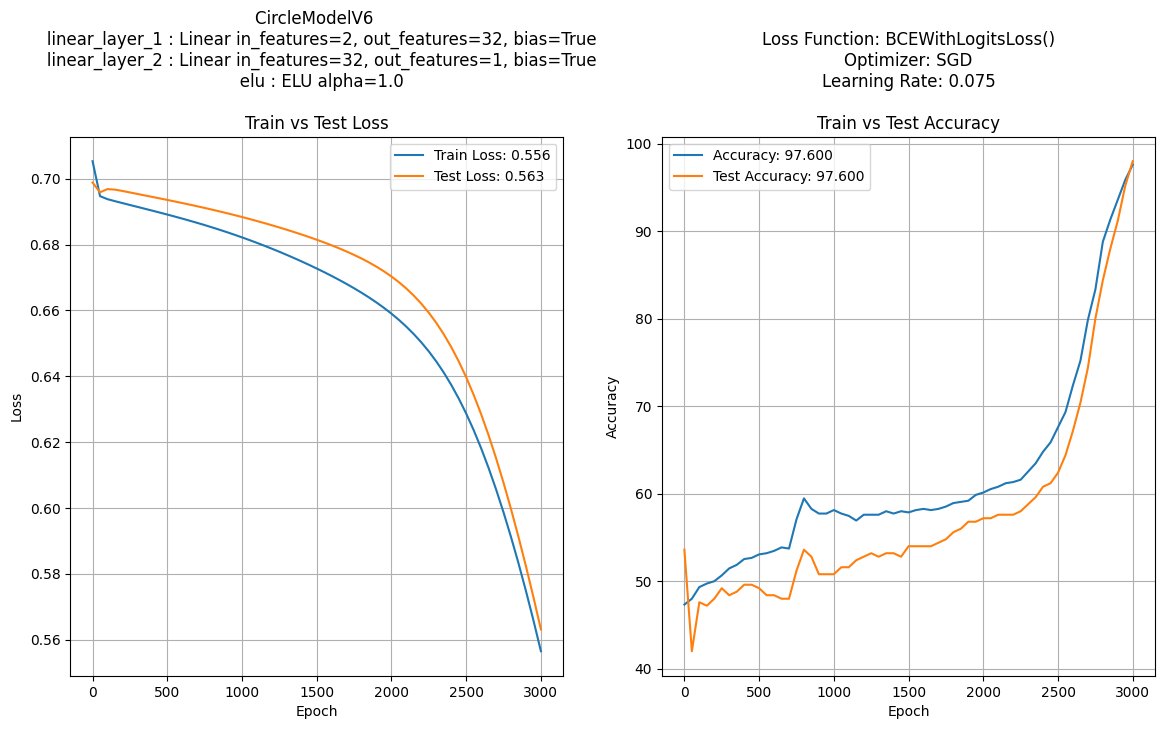

In [292]:
model_6_graphs = plot_graphs(model_6_architecture, epochs_count_6, loss_values_6, final_loss_6, test_loss_values_6, final_test_loss_6, acc_values_6, final_acc_6, test_acc_values_6, final_acc_6, loss_fn_6, optimizer_6_name, learning_rate_6)

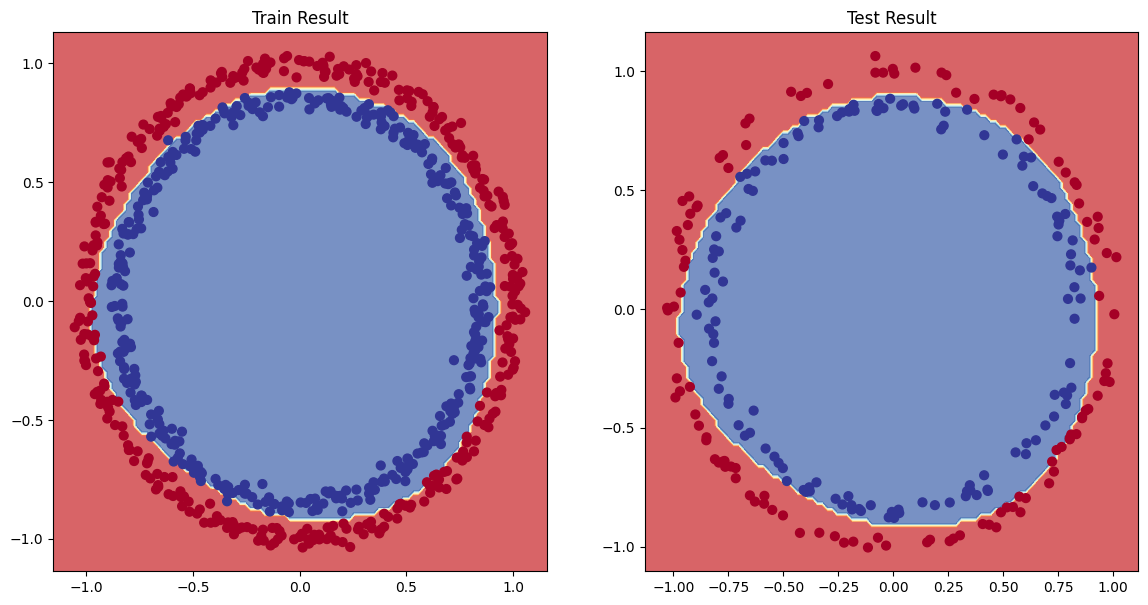

In [293]:
model_6_results = plot_results(model_6, X_train, y_train, X_test, y_test)

In [294]:
print(results_1)
print(results_2)
print(results_3)
print(results_4)
print(results_5)
print(results_6)

{'Model': 'CircleModelV1', 'Loss': 0.6926953196525574, 'Test Loss': 0.6962283849716187, 'Acc': 50.0, 'Test Acc': 46.400000000000006}
{'Model': 'CircleModelV2', 'Loss': 0.31390783190727234, 'Test Loss': 0.32598233222961426, 'Acc': 99.6, 'Test Acc': 99.6}
{'Model': 'CircleModelV3', 'Loss': 0.2635451555252075, 'Test Loss': 0.26703718304634094, 'Acc': 100.0, 'Test Acc': 100.0}
{'Model': 'CircleModelV4', 'Loss': 0.4202127754688263, 'Test Loss': 0.4241825342178345, 'Acc': 100.0, 'Test Acc': 100.0}
{'Model': 'CircleModelV5', 'Loss': 0.5564867258071899, 'Test Loss': 0.5631148219108582, 'Acc': 97.6, 'Test Acc': 98.0}
{'Model': 'CircleModelV6', 'Loss': 0.5564867258071899, 'Test Loss': 0.5631148219108582, 'Acc': 97.6, 'Test Acc': 98.0}
